# ML Case Study 1

## Was ist ML Case Study?

In der ML Case Study gehen wir gemeinsam tief für ein spezifischen Problemfall. Dies soll den ML-Alltag näher bringen. Im Alltag werdet ihr andere Probleme anders angehen müssen. 

## In diesem ML Case..

In dieser ML Case Study schauen wir uns die Binäre Klassifizierung genauer an.

Das Notebook ist von https://www.ritchieng.com/machine-learning-evaluate-classification-model/#Topics übernommen und fürs CAS angepasst.

## Daten

Datensatz Beschreibung: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

In [236]:
import pandas as pd
import seaborn as sns

In [237]:
pima = pd.read_csv('data/pima-indians-diabetes.csv')

In [238]:
pima.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [239]:
X = pima[['Pregnancies', 'Insulin', 'BMI', 'Age']]
y = pima['Outcome']

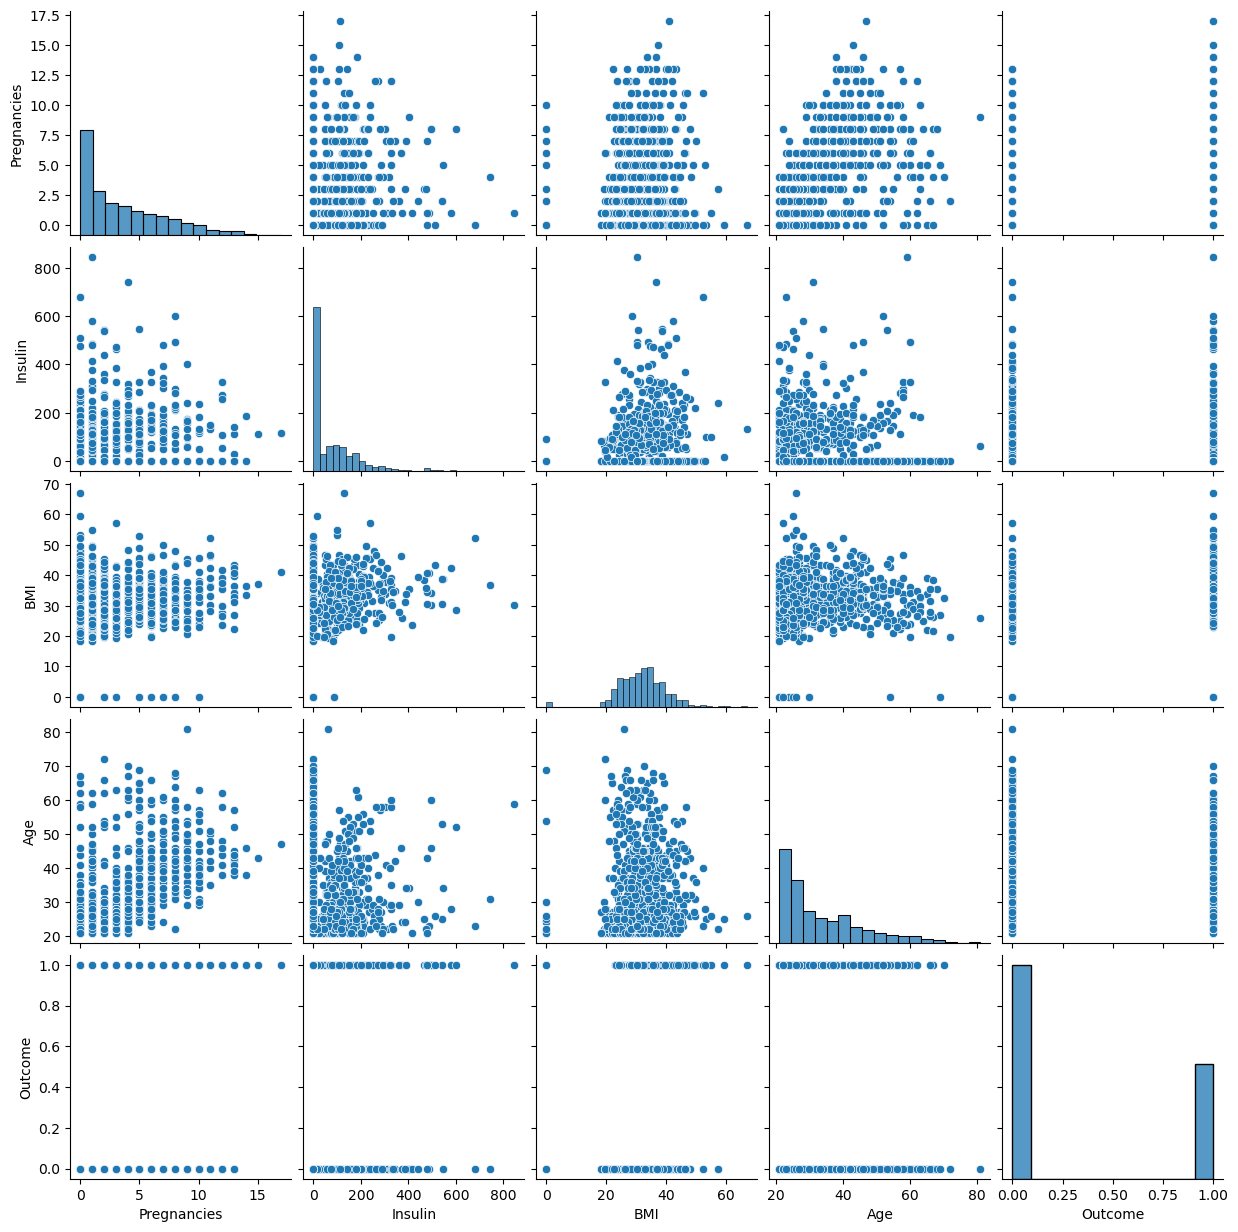

In [240]:
sns.pairplot(pima[['Pregnancies', 'Insulin', 'BMI', 'Age', 'Outcome']])

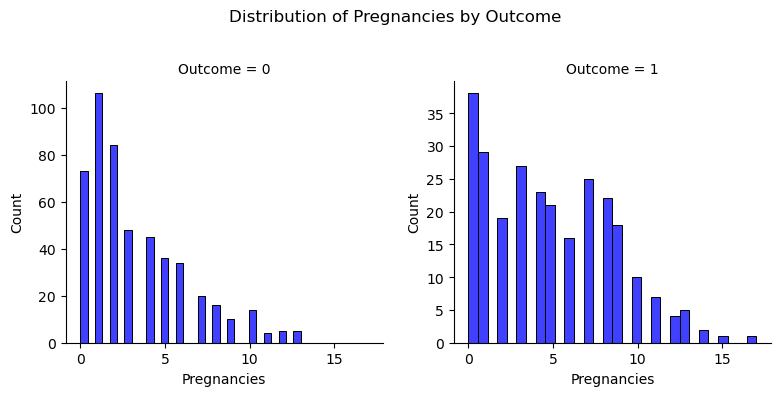

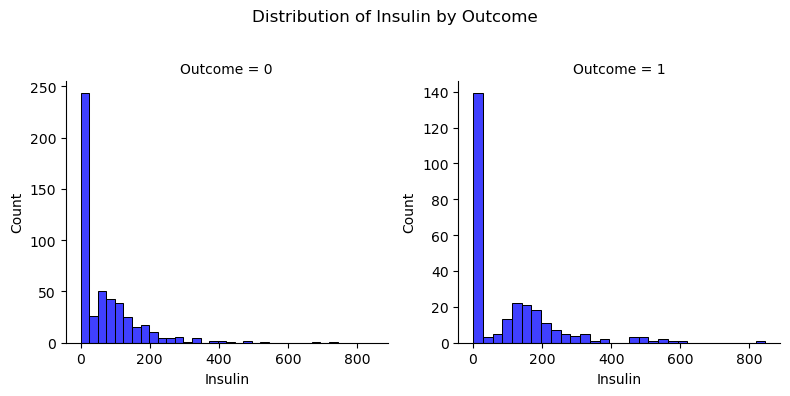

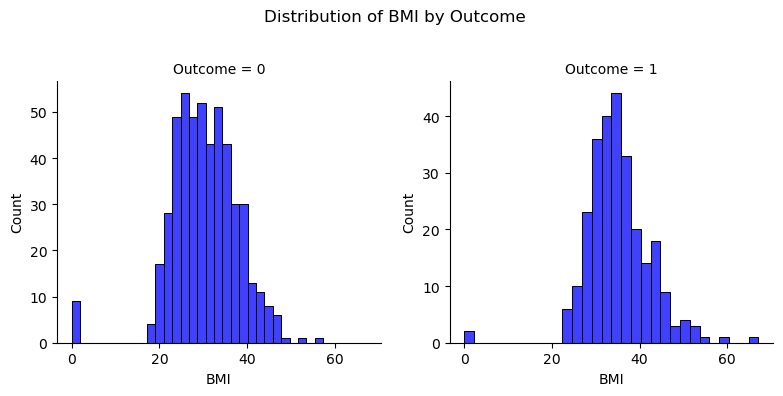

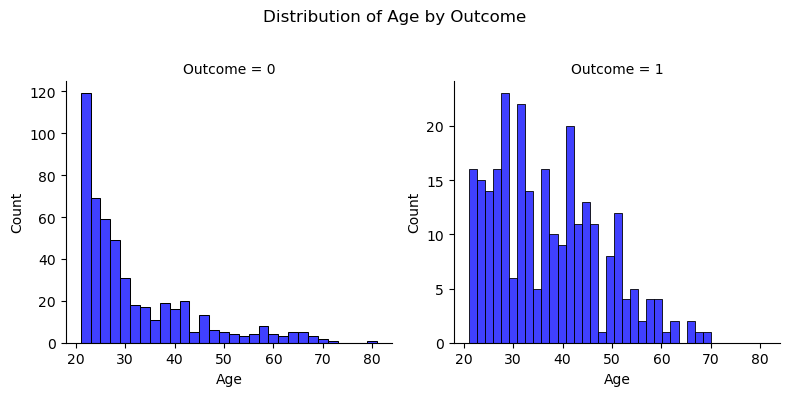

In [241]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = ['Pregnancies', 'Insulin', 'BMI', 'Age']

for col in cols:
    g = sns.FacetGrid(pima, col="Outcome", height=4, sharex=True, sharey=False)
    g.map(sns.histplot, col, kde=False, bins=30, color='b')
    plt.subplots_adjust(top=0.8)
    g.fig.suptitle(f'Distribution of {col} by Outcome')  # Adjust the title for each feature
    plt.show()

## Erstes Modell

### Data Cleaning mit ZeroToMeanImputer

In [242]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class ZeroToMeanImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.means_ = {}

    def fit(self, X, y=None):
        # Compute the mean of specified columns from the training data
        if self.columns is None:
            self.columns = X.columns
        for column in self.columns:
            self.means_[column] = X[column].replace(0, np.nan).mean()
        return self

    def transform(self, X):
        # Replace '0' with the mean value in the specified columns
        for column in self.columns:
            X.loc[X[column] == 0, column] = self.means_[column]
        return X

In [243]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_predict

lr = Pipeline([
    ('clean', ZeroToMeanImputer(['BMI'])),
    ('std', StandardScaler()),
    ('clf', LogisticRegression()),
])

y_hat_lr = cross_val_predict(lr, X, y, cv=5)

print(f'Accuracy: {accuracy_score(y, y_hat_lr):.4f}')

Accuracy: 0.6901


<table>
<tr>
<td>
    <img src="questions.png" alt="Your image" style="width: 100px;"/> <!-- You can adjust the width here -->
</td>
<td style="vertical-align: top; padding: 20px;"> <!-- This adds some space between the image and the text -->
    <ul>
     <li>Was macht der ZeroToMeanImputer?</li> 
     <li>Ist das ein gutes Resultat?</li> 
     <li>Wir möchte das Modell einsetzen, indem er eine Web-Applikation anbietet. Leute können ihre Werte eingeben können und unser Modell macht eine Vorhersage. Dies soll gemeinnützig sein und das Gesundheitssystem entlasten, da die Leute so zuerst abwiegen können, ob ein Arzt Besuch überhaupt nötig ist. Zurzeit hat das Gesundheitssystem zu wenig Personal, sprich jeder unnötiger Arzt Besuch den wir stoppen können, wäre hilfreich. Was denkst du, kann unser Modell so eingesetzt werden? Begründe!</li>
     </ul>
</td>
</tr>
</table>


# Ist das ein gutes Resultat?

Antwort: Nein.

Begründung: 
Bei zwei Klassen ist ein zufälliges Raten bei 50% Genauigkeit, dann wäre 70% schon eine starke Verbesserung.
Aber in diesem Datensatz ist der Outcome nicht uniform verteilt, sondern die eine Klasse kommt mehr vor (Siehe "Distribution of Outcome")
Wir könnten also einen Klassifier machen, der einfach immer Outcome `0` vorhersagt und die Accuracy wäre deutlich über 50%.
Wenn wir das machen und auch mit k-fold cross validation validieren, bekommen wir eine Accuracy von 65%.
70% ist noch besser als 65%, aber nicht mehr so viel. Sprich das Modell ist 5% genauer als ein Modell, dass nicht einmal auf die Features schaut. 

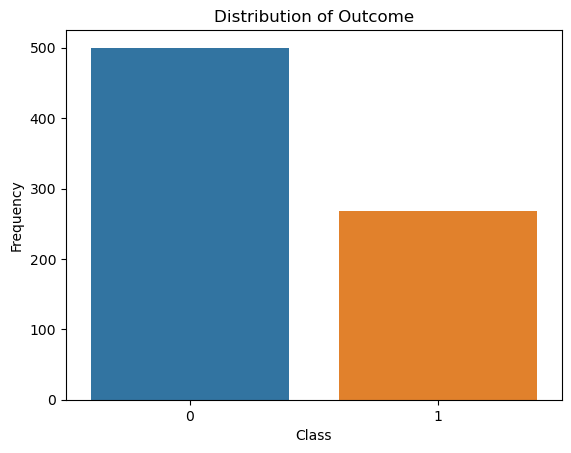

In [244]:
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = y.value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of Outcome')
plt.show()

In [245]:
from sklearn.dummy import DummyClassifier

# Create the DummyClassifier to always predict the most frequent class (Baseline model)
dummy = DummyClassifier(strategy='most_frequent')

y_hat_dummy = cross_val_predict(dummy, X, y, cv=5)

# A good model should beat this accuracy, as this model does not even look at the features!
print(accuracy_score(y, y_hat_dummy))

0.6510416666666666


## Kann unser Modell so eingesetzt werden?

Antwort: Nein!

Begründung:
1. Domain-Shift: Daten betreffen nicht Schweizer:innen im 2023. 
2. Wir müssen erst einmal verstehen, was unser Modell genau macht. Wo machen wir die Fehler? 
3. Generelle Einsatz-Idee ist falsch/gefährlich => Regulierung

Wie können wir herausfinden, wo wir die Fehler machen?

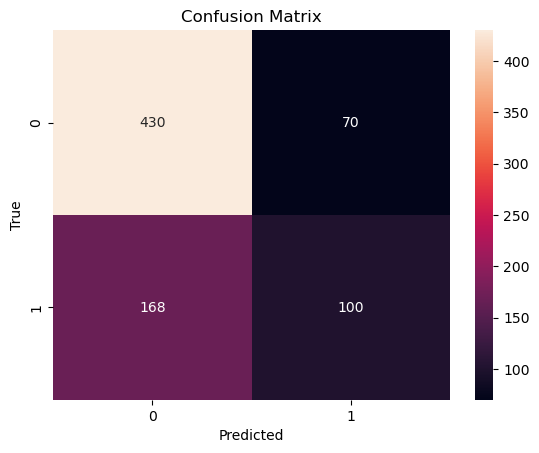

In [246]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(conf_matrix):
    # Plot confusion matrix nicely with seaborn
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

conf_matrix = confusion_matrix(y, y_hat_lr)
plot_confusion_matrix(conf_matrix)
plt.show()

<table>
<tr>
<td>
    <img src="questions.png" alt="Your image" style="width: 100px;"/> <!-- You can adjust the width here -->
</td>
<td style="vertical-align: top; padding: 20px;"> <!-- This adds some space between the image and the text -->
    <ul>
         <li>Wo machen wir Fehler?</li>
         <li>Was sind die Folgen der Fehler für das jeweilige Szenario?</li>
     </ul>
</td>
</tr>
</table>


Antwort: Wir haben 67 False Positives, sprich wir sagen Leuten sie haben Diabetes, obwohl sie es nicht haben.
Und wir haben 167 False Negatives, sprich wir sagen Leuten sie haben kein Diabetes, obwohl sie es haben.
Der zweite Fall ist schlimmer, weil in dem oben beschriebenen Szenario würde die Person dann nicht zum Arzt gehen, obwohl sie eine Behandlung bräuchte. 
=> Recall ist wichtiger als Precision!

In [247]:
from sklearn.metrics import precision_score, recall_score

print(f'Precision: {precision_score(y, y_hat_lr):.4f}')
print(f'Recall: {recall_score(y, y_hat_lr):.4f}')


Precision: 0.5882
Recall: 0.3731


## Andere Beispiele

- Spamfilter (positive Klasse ist "Spam"):
False Negatives (Spam gelangt in den Posteingang) ist akzeptabler als False Positives (Nicht-Spam wird vom Spamfilter erfasst).
=> Precision ist wichtiger als Recall!

- Betrugserkennung bei Transaktionen (positive Klasse ist "Betrug"):
False Positive (normale Transaktionen, die als möglicher Betrug markiert sind) ist akzeptabler als False Negative (nicht erkannte betrügerische Transaktionen)
=> Recall ist wichtiger als Precision!

[[0.5158602 0.4841398]
 [0.8596348 0.1403652]]


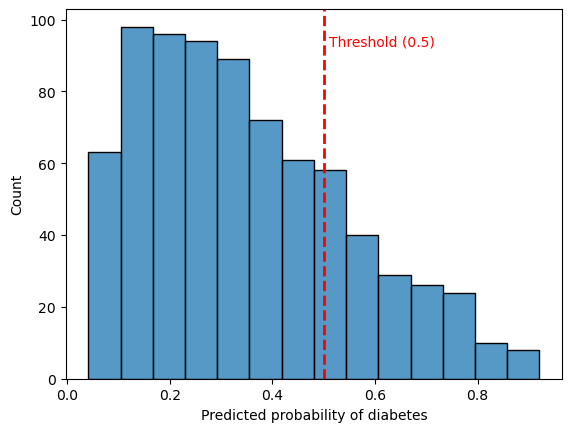

In [248]:
# store the predicted probabilities for class 1
y_hat_lr_prob = cross_val_predict(lr, X, y, cv=5, method='predict_proba')
print(y_hat_lr_prob[0:2, :])
y_hat_lr_prob = y_hat_lr_prob[:, 1]  # Take probability for class '1'

# histogram of predicted probabilities
sns.histplot(y_hat_lr_prob)
plt.xlabel('Predicted probability of diabetes')
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2)
plt.text(0.51, plt.gca().get_ylim()[1]*0.9, 'Threshold (0.5)', color = 'red')
plt.show()

<table>
<tr>
<td>
    <img src="questions.png" alt="Your image" style="width: 100px;"/> <!-- You can adjust the width here -->
</td>
<td style="vertical-align: top; padding: 20px;"> <!-- This adds some space between the image and the text -->
    <ul>
         <li>Was passiert, wenn wir den Threshold vergrössern? Verkleinern?</li>
         <li>Wie können wir den Recall verbessern?</li>
         <li>Wie weit kann man und wie weit sollte man gehen?</li>
     </ul>
</td>
</tr>
</table>


## Threshold Moving

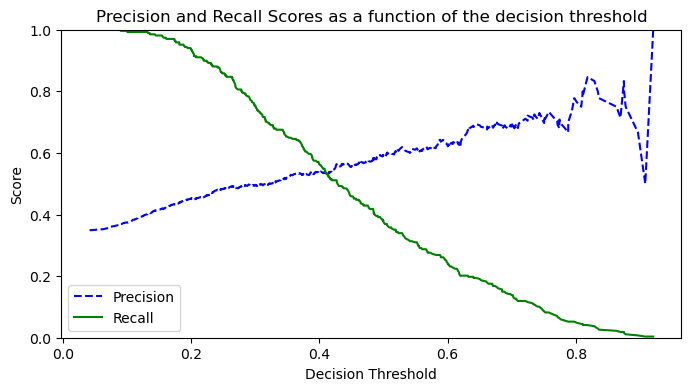

In [249]:
from sklearn.metrics import precision_recall_curve


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Plot precision and recall as functions of the decision threshold.
    """
    plt.figure(figsize=(8, 4))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.ylim([0,1])

precisions, recalls, thresholds = precision_recall_curve(y, y_hat_lr_prob)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

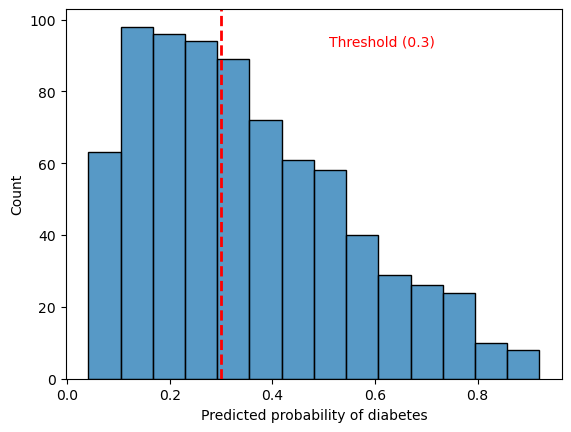

Precision: 0.4963
Recall: 0.7537
Accuracy: 0.6471


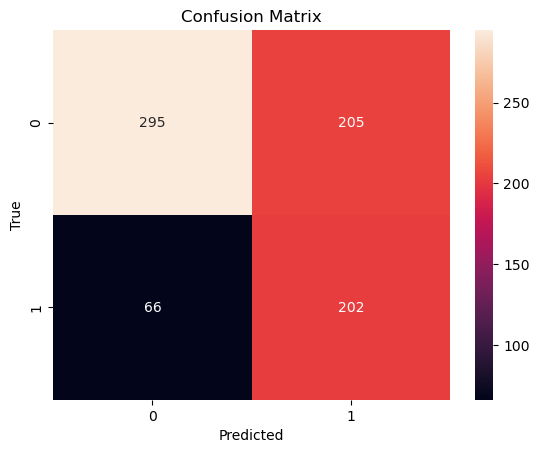

In [250]:
from sklearn.preprocessing import binarize
y_hat_lr_03 = binarize(y_hat_lr_prob.reshape(-1, 1), threshold=0.3).flatten()

# histogram of predicted probabilities
sns.histplot(y_hat_lr_prob)
plt.xlabel('Predicted probability of diabetes')
plt.axvline(x=0.3, color='red', linestyle='--', linewidth=2)
plt.text(0.51, plt.gca().get_ylim()[1]*0.9, 'Threshold (0.3)', color = 'red')
plt.show()

conf_matrix = confusion_matrix(y, y_hat_lr_03)
from sklearn.metrics import precision_score, recall_score
print(f'Precision: {precision_score(y, y_hat_lr_03):.4f}')
print(f'Recall: {recall_score(y, y_hat_lr_03):.4f}')
print(f'Accuracy: {accuracy_score(y, y_hat_lr_03):.4f}')
plot_confusion_matrix(conf_matrix)
plt.show()

Precision: 0.3736
Recall: 0.9925
Accuracy: 0.4167


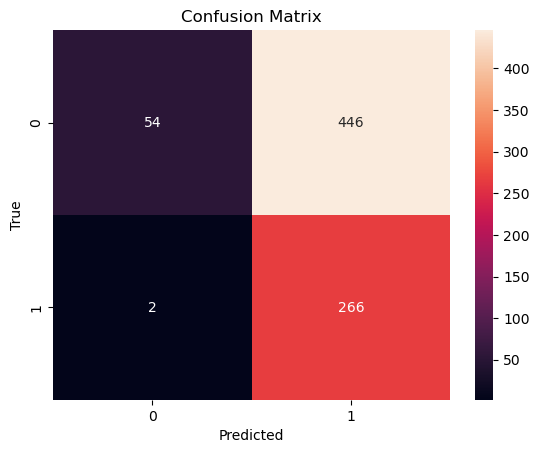

In [251]:
from sklearn.preprocessing import binarize
y_hat_lr_01 = binarize(y_hat_lr_prob.reshape(-1, 1), threshold=0.1).flatten()

conf_matrix = confusion_matrix(y, y_hat_lr_01)
print(f'Precision: {precision_score(y, y_hat_lr_01):.4f}')
print(f'Recall: {recall_score(y, y_hat_lr_01):.4f}')
print(f'Accuracy: {accuracy_score(y, y_hat_lr_01):.4f}')
plot_confusion_matrix(conf_matrix)
plt.show()

Extra: Trade-off von Precision und Recall kann mit dem F-$\beta$ Score gemacht werden (Siehe [https://en.wikipedia.org/wiki/F-score](https://en.wikipedia.org/wiki/F-score))

## ROC Curve and AUC (area under the curve) als Metrik

AUC von ROC ist eine mögliche Metrik. Schauen wir zuerst mal die Begriffe an.

### ROC

Die ROC-Kurve (Receiver Operating Characteristics) visualisiert die Leistung eines Klassifizierungsmodells, indem sie die True Positive Rate (auch Recall) gegen die False Positive Rate (FPR) bei verschiedenen Schwellenwerten darstellt. Die Steilheit der ROC-Kurve ist ein Indikator für die Trennschärfe des Modells: je steiler die Kurve, desto besser die Trennfähigkeit des Modells bei einem gegebenen Schwellenwert. Eine diagonale Linie von der unteren linken zur oberen rechten Ecke entspricht einem zufälligen Classifier.

**TPR (True Positive Rate)** misst den Anteil der tatsächlich Positiven, die korrekt als solche identifiziert wurden:
$$ TPR = \frac{TP}{TP + FN} $$
**FPR (False Positive Rate)** misst den Anteil der tatsächlich Negativen, die fälschlicherweise als Positiv identifiziert wurden:
$$ FPR = \frac{FP}{FP + TN} $$

Die Fläche unter der ROC Kurve kann als Metrik für einen Classifier verwendet werden.

### AUC

Die AUC (Area Under the Curve) einer ROC (Receiver Operating Characteristics)-Kurve misst die Diskriminierungsfähigkeit eines Klassifizierungsmodells, unabhängig von festgelegten Schwellenwerten. Sie gibt die Wahrscheinlichkeit an, dass ein positives Beispiel höher als ein negatives Beispiel eingestuft wird. Eine AUC von 1 zeigt perfekte Diskriminierung, 0,5 keine bessere als Zufall und unter 0,5 eine Diskriminierung schlechter als Zufall an.

### Wann?

ROC und AUC sind Metriken für die Wahrscheinlichkeiten einer **binären** Klassifikation. 
Die Anwendung auf Modelle ohne Wahrscheinlichkeit (z.B. SVM) kann gemacht werden, ist meistens aber ein wenig ”hacky", da man einfach z.B. bei der SVM die Distanz zur Decision Boundary als Score interpretiert.



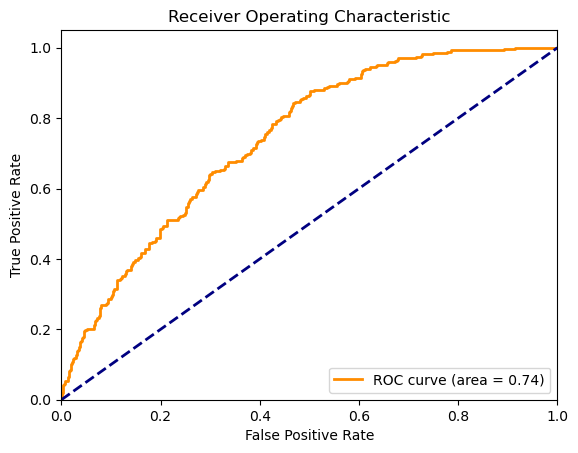

In [252]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y, y_hat_lr_prob)

roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Extra: Man kann die AUC für ROC auch folgendermassen direkt berechnen:

In [253]:
from sklearn.model_selection import cross_val_score

cross_val_score(lr, X, y, cv=5, scoring='roc_auc').mean()

0.7441977638015373